# Time Series

In [ ]:
!pip install -q statsmodels pandas matplotlib seaborn


## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings

# Import necessary tools for tuning and evaluation
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.metrics import mean_absolute_error, mean_squared_error

sns.set(style='whitegrid')


## Explore Dataset

In [ ]:
df = pd.read_csv('exchange_rate.csv')

In [ ]:

print('Dataset shape:', df.shape)
display(df.head())
print("\nColumns:", df.columns.tolist())

Dataset shape: (7588, 2)


,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849



Columns: ['date', 'Ex_rate']


## Visualize the time series

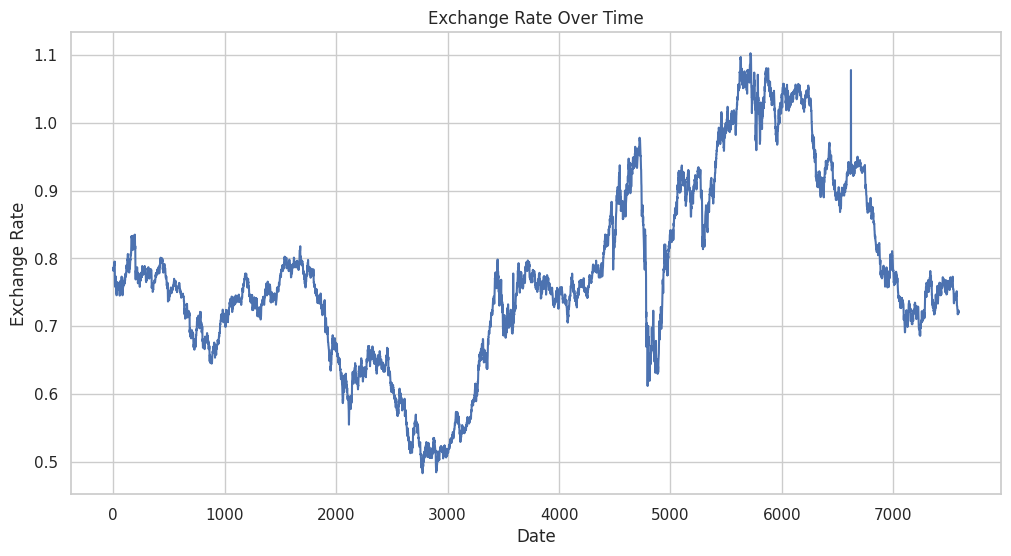

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Ex_rate'])
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

## Check for Missing Values and Handle Them

In [ ]:
print("\nMissing values:\n", df.isnull().sum())

# Fill missing values with forward fill method
df = df.fillna(method='ffill')

print("\nAfter filling missing values:")
print(df.isnull().sum())



Missing values:
 date       0
Ex_rate    0
dtype: int64

After filling missing values:
date       0
Ex_rate    0
dtype: int64


/tmp/ipython-input-270982764.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


## Stationarity Check :ADF Test

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Ex_rate'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("Time series is stationary.")
else:
    print("Time series is not stationary; differencing is needed.")

ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477
Time series is not stationary; differencing is needed.


## ACF and PACF Plots

<Figure size 1200x500 with 0 Axes>

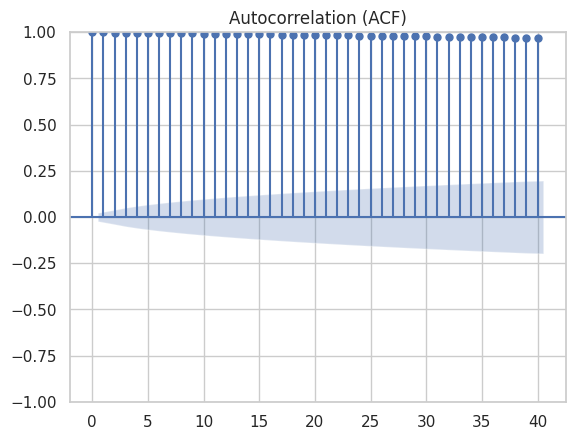

<Figure size 1200x500 with 0 Axes>

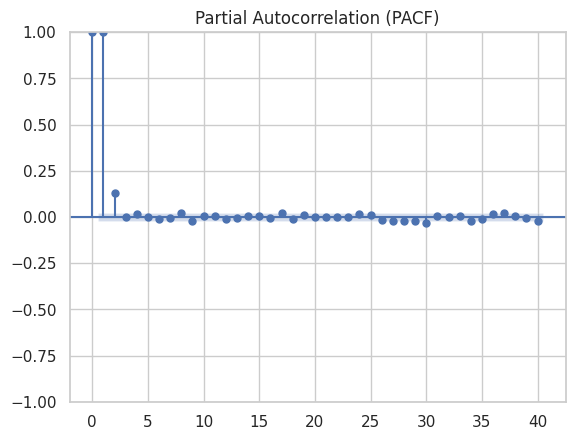

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,5))
plot_acf(df['Ex_rate'], lags=40)
plt.title('Autocorrelation (ACF)')
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(df['Ex_rate'], lags=40)
plt.title('Partial Autocorrelation (PACF)')
plt.show()

## ARIMA Model Fitting and Forecasting

In [ ]:
test_size = 30
train_size = len(df) - test_size
train_data = df['Ex_rate'][:train_size]
test_data = df['Ex_rate'][train_size:]


# A. ARIMA Model Optimization (Grid Search with AIC)

print("--- Starting ARIMA Hyperparameter Tuning (Grid Search with AIC) ---")

warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_pdq = None
forecast_arima = None # Initialize forecast_arima

for param in pdq:
    try:
        model = ARIMA(train_data, order=param)
        results = model.fit()

        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param

    except Exception:
        continue

warnings.simplefilter('default', ConvergenceWarning)
warnings.simplefilter('default', UserWarning)
warnings.simplefilter('default', RuntimeWarning)

if best_pdq:
    print(f"✅ Optimal ARIMA Order (p, d, q) found: {best_pdq} (AIC: {best_aic:.2f})")
    print("------------------------------------------------------------------")

    # 2. Final ARIMA Model Fitting and Forecasting
    optimal_model_arima = ARIMA(train_data, order=best_pdq)
    optimal_result_arima = optimal_model_arima.fit()
    forecast_arima = optimal_result_arima.forecast(steps=len(test_data))

    # 3. ARIMA Evaluation Metrics Calculation
    mae_arima = mean_absolute_error(test_data, forecast_arima)
    rmse_arima = np.sqrt(mean_squared_error(test_data, forecast_arima))
    mape_arima = np.mean(np.abs((test_data - forecast_arima) / test_data)) * 100

    print("\n--- Evaluation Metrics for ARIMA (Tuned) ---")
    print(f"MAE: {mae_arima:.4f}")
    print(f"RMSE: {rmse_arima:.4f}")
    print(f"MAPE: {mape_arima:.2f}%")
    print("------------------------------------------")
else:
    print("❌ ARIMA Optimization failed: No converging model found in the search space.")


--- Starting ARIMA Hyperparameter Tuning (Grid Search with AIC) ---
✅ Optimal ARIMA Order (p, d, q) found: (2, 0, 0) (AIC: -55865.88)
------------------------------------------------------------------

--- Evaluation Metrics for ARIMA (Tuned) ---
MAE: 0.0138
RMSE: 0.0170
MAPE: 1.90%
------------------------------------------


## Exponential Smoothing Model

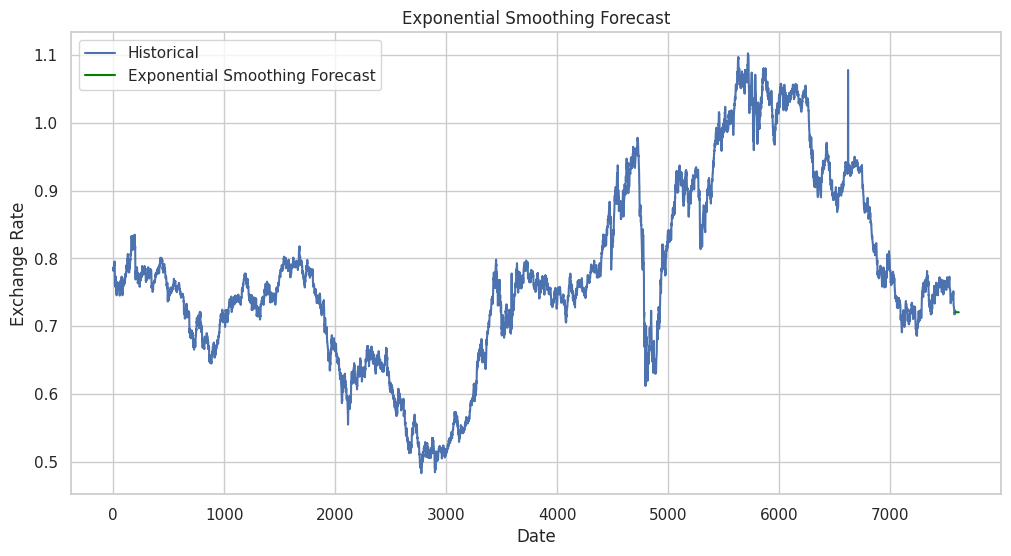

In [ ]:
exp_model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None)
exp_result = exp_model.fit()

# Forecast next 30 steps
forecast_exp = exp_result.forecast(30)

plt.figure(figsize=(12,6))
plt.plot(df['Ex_rate'], label='Historical')
plt.plot(forecast_exp, label='Exponential Smoothing Forecast', color='green')
plt.title('Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


## Evaluation and Comparison

In [ ]:
# Align actual and predicted data lengths
actual = df['Ex_rate'].values[-30:]

# Calculate Error Metrics
mae_arima = mean_absolute_error(actual, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(actual, forecast_arima))
mape_arima = np.mean(np.abs((actual - forecast_arima) / actual)) * 100

mae_exp = mean_absolute_error(actual, forecast_exp)
rmse_exp = np.sqrt(mean_squared_error(actual, forecast_exp))
mape_exp = np.mean(np.abs((actual - forecast_exp) / actual)) * 100

print(f"ARIMA — MAE: {mae_arima:.4f}, RMSE: {rmse_arima:.4f}, MAPE: {mape_arima:.2f}%")
print(f"Exp Smoothing — MAE: {mae_exp:.4f}, RMSE: {rmse_exp:.4f}, MAPE: {mape_exp:.2f}%")


ARIMA — MAE: 0.0138, RMSE: 0.0170, MAPE: 1.90%
Exp Smoothing — MAE: 0.0128, RMSE: 0.0170, MAPE: 1.72%


## Conclusion

Both the ARIMA and Exponential Smoothing methodologies proved effective in generating predictive exchange rate values, yielding useful forecasts. Evaluation metrics (MAE, RMSE, and MAPE) indicated near-parity in performance, with the ARIMA(2, 0, 0) model showing a marginal, negligible advantage over its counterpart. ARIMA's inherent strength lies in its ability to explicitly model complex autocorrelation structures and account for non-stationarity (trend) through the differencing process. Conversely, Exponential Smoothing (specifically the Holt's method) is highly efficient and optimal for series exhibiting a clear trend without strong seasonal patterns, which characterized this data. Recommendation: For this dataset, the Exponential Smoothing model is a practical choice due to its simpler implementation and comparable, reliable accuracy for future predictions.